# BERT fine-tuning

In [1]:
from transformers import BertTokenizer, AutoModelForSequenceClassification, AutoTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import logging

from sklearn.model_selection import train_test_split

import keras
import accelerate

from datasets import Dataset

from tokenizers import Tokenizer, models, trainers
from tokenizers.pre_tokenizers import WhitespaceSplit, Split, Sequence
import re


In [2]:
data_df = pd.read_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/data/reduced_prompt_data.csv')

In [3]:
data_df.columns

Index(['Unnamed: 0', 'Prompts', 'turbidity'], dtype='object')

In [4]:
from tokenizers import Tokenizer, models, trainers
from tokenizers.pre_tokenizers import WhitespaceSplit, Split, Sequence
import re

text_data = data_df["Prompts"].tolist()

smiles_pattern = r"[A-Za-z0-9@+\-=#()/%]+"  

tokenizer = Tokenizer(models.WordLevel(unk_token="[UNK]"))

tokenizer.pre_tokenizer = Sequence([
    WhitespaceSplit(),  
    Split(smiles_pattern, behavior="isolated") 
])


trainer = trainers.WordLevelTrainer(
    vocab_size=30522,
    special_tokens=["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
)

tokenizer.train_from_iterator(text_data, trainer)

tokenizer.save("/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/word_level_tokenizer.json")


In [5]:
data_df.rename(columns={'turbidity': 'labels', 'Prompts': 'Prompt'}, inplace=True)

In [6]:
data_df

,Unnamed: 0,Prompt,labels
0,0,Would the mixture involving the ditopic O=Cc1c...,0
1,1,Would the mixture involving the ditopic CC(C)(...,0
2,2,Would the mixture involving the ditopic O=Cc1c...,0
3,3,Would the mixture involving the ditopic O=Cc1c...,0
4,4,Would the mixture involving the ditopic O=Cc1c...,0
...,...,...,...
343,343,Would the mixture involving the ditopic NCCOCC...,1
344,344,Would the mixture involving the ditopic NCC1=C...,1
345,345,Would the mixture involving the ditopic NCC(CN...,1
346,346,Would the mixture involving the ditopic NCCCC[...,1


In [8]:
custom_tokenizer = Tokenizer.from_file("/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/word_level_tokenizer.json")

def tokenize_function(batch):

    prompts = [str(text) for text in batch["Prompt"]]
    
    input_ids = []
    attention_masks = []
    for text in prompts:
        tokens = tokenizer.encode(text)
        input_ids.append(tokens.ids)
        attention_masks.append(tokens.attention_mask)
    
    return {
        "input_ids": input_ids,
        "attention_mask": attention_masks
    }

data_df["Prompt"] = data_df["Prompt"].astype(str)  
dataset = Dataset.from_pandas(data_df)
dataset = dataset.map(tokenize_function, batched=True)

train_dataset, eval_dataset = dataset.train_test_split(test_size=0.2).values()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/348 [00:00<?, ? examples/s]

In [9]:
print("Sample input_ids:", train_dataset['input_ids'][:5])
print("Sample attention_mask:", train_dataset['attention_mask'][:5])

Sample input_ids: [[23, 5, 40, 38, 5, 10, 197, 9, 11, 134, 31, 30, 29, 47, 41, 33, 20, 21, 5, 35, 44, 24, 46, 12, 14, 7, 27, 36, 13, 5, 10, 8, 6, 51, 9, 7, 5, 11, 8, 6, 66, 12, 14, 7, 16, 15, 25, 13, 5, 10, 8, 6, 65, 9, 7, 5, 11, 8, 6, 61, 12, 14, 7, 16, 15, 34, 13, 5, 10, 8, 6, 49, 9, 7, 5, 11, 8, 6, 48, 12, 14, 7, 37, 28, 13, 5, 10, 8, 6, 167, 9, 7, 5, 11, 8, 6, 127, 12, 39, 18, 42, 32, 7, 5, 10, 8, 6, 173, 9, 7, 5, 11, 8, 6, 126, 12, 22, 19, 43, 45, 26, 7, 5, 10, 8, 6, 180, 9, 7, 5, 11, 8, 6, 77], [23, 5, 40, 38, 5, 10, 149, 9, 11, 120, 31, 30, 29, 47, 41, 33, 20, 21, 5, 35, 44, 24, 46, 12, 14, 7, 27, 36, 13, 5, 10, 8, 6, 49, 9, 7, 5, 11, 8, 6, 52, 12, 14, 7, 16, 15, 25, 13, 5, 10, 8, 6, 51, 9, 7, 5, 11, 8, 6, 48, 12, 14, 7, 16, 15, 34, 13, 5, 10, 8, 6, 17, 9, 7, 5, 11, 8, 6, 50, 12, 14, 7, 37, 28, 13, 5, 10, 8, 6, 58, 9, 7, 5, 11, 8, 6, 59, 12, 39, 18, 42, 32, 7, 5, 10, 8, 6, 137, 9, 7, 5, 11, 8, 6, 60, 12, 22, 19, 43, 45, 26, 7, 5, 10, 8, 6, 82, 9, 7, 5, 11, 8, 6, 54], [23, 5, 40,

In [10]:
print("Sample input_ids:", eval_dataset['input_ids'][:5])


Sample input_ids: [[23, 5, 40, 38, 5, 10, 164, 9, 11, 111, 31, 30, 29, 47, 41, 33, 20, 21, 5, 35, 44, 24, 46, 12, 14, 7, 27, 36, 13, 5, 10, 8, 6, 55, 9, 7, 5, 11, 8, 6, 57, 12, 14, 7, 16, 15, 25, 13, 5, 10, 8, 6, 51, 9, 7, 5, 11, 8, 6, 61, 12, 14, 7, 16, 15, 34, 13, 5, 10, 8, 6, 17, 9, 7, 5, 11, 8, 6, 90, 12, 14, 7, 37, 28, 13, 5, 10, 8, 6, 84, 9, 7, 5, 11, 8, 6, 73, 12, 39, 18, 42, 32, 7, 5, 10, 8, 6, 79, 9, 7, 5, 11, 8, 6, 89, 12, 22, 19, 43, 45, 26, 7, 5, 10, 8, 6, 82, 9, 7, 5, 11, 8, 6, 104], [23, 5, 40, 38, 5, 10, 156, 9, 11, 115, 31, 30, 29, 47, 41, 33, 20, 21, 5, 35, 44, 24, 46, 12, 14, 7, 27, 36, 13, 5, 10, 8, 6, 49, 9, 7, 5, 11, 8, 6, 52, 12, 14, 7, 16, 15, 25, 13, 5, 10, 8, 6, 65, 9, 7, 5, 11, 8, 6, 56, 12, 14, 7, 16, 15, 34, 13, 5, 10, 8, 6, 51, 9, 7, 5, 11, 8, 6, 50, 12, 14, 7, 37, 28, 13, 5, 10, 8, 6, 58, 9, 7, 5, 11, 8, 6, 59, 12, 39, 18, 42, 32, 7, 5, 10, 8, 6, 141, 9, 7, 5, 11, 8, 6, 99, 12, 22, 19, 43, 45, 26, 7, 5, 10, 8, 6, 146, 9, 7, 5, 11, 8, 6, 106], [23, 5, 40, 3

In [11]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

train_dataset = train_dataset.map(lambda x: {"labels": int(x["labels"])})
eval_dataset = eval_dataset.map(lambda x: {"labels": int(x["labels"])})

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
eval_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/278 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

In [12]:
from transformers import PreTrainedTokenizerFast

hf_tokenizer = PreTrainedTokenizerFast(tokenizer_file="/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/word_level_tokenizer.json")
hf_tokenizer.pad_token = "[PAD]"
hf_tokenizer.cls_token = "[CLS]"
hf_tokenizer.sep_token = "[SEP]"
hf_tokenizer.mask_token = "[MASK]"
hf_tokenizer.unk_token = "[UNK]"


In [13]:
import evaluate
import numpy as np
from transformers import Trainer, TrainingArguments

accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return {"accuracy": accuracy["accuracy"]}

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=hf_tokenizer,
    compute_metrics=compute_metrics
)




/Users/davidsegura/miniconda3/envs/env_cage/lib/python3.9/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_91098/2586569330.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [14]:
trainer.train()
results = trainer.evaluate()
print(results)

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.698342502117157, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 3.7161, 'eval_samples_per_second': 18.837, 'eval_steps_per_second': 2.422, 'epoch': 1.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6919854879379272, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 5.2619, 'eval_samples_per_second': 13.303, 'eval_steps_per_second': 1.71, 'epoch': 2.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6968165636062622, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 3.4097, 'eval_samples_per_second': 20.53, 'eval_steps_per_second': 2.64, 'epoch': 3.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.7062683701515198, 'eval_accuracy': 0.4, 'eval_runtime': 3.3763, 'eval_samples_per_second': 20.733, 'eval_steps_per_second': 2.666, 'epoch': 4.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.7035678625106812, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 3.1082, 'eval_samples_per_second': 22.521, 'eval_steps_per_second': 2.896, 'epoch': 5.0}
{'train_runtime': 294.9783, 'train_samples_per_second': 4.712, 'train_steps_per_second': 0.593, 'train_loss': 0.6994365583147322, 'epoch': 5.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.7035678625106812, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 3.2557, 'eval_samples_per_second': 21.501, 'eval_steps_per_second': 2.764, 'epoch': 5.0}


# PLOTTING

In [461]:
from transformers import TrainerCallback

class CustomCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.eval_losses = []
        self.eval_accuracies = []

    def on_epoch_end(self, args, state, control, **kwargs):

        if 'trainer' in kwargs:
            trainer = kwargs['trainer'] 
            eval_results = trainer.evaluate()  
            print("Evaluation Results:", eval_results)  
            self.eval_losses.append(eval_results.get("eval_loss", None))
            self.eval_accuracies.append(eval_results.get("eval_accuracy", None))  

In [462]:
custom_callback = CustomCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=hf_tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[custom_callback]  
)

trainer.train()


/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_44453/4008845704.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.7011894583702087, 'eval_accuracy': 0.5, 'eval_runtime': 3.4816, 'eval_samples_per_second': 20.105, 'eval_steps_per_second': 2.585, 'epoch': 1.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6983897686004639, 'eval_accuracy': 0.5, 'eval_runtime': 3.2239, 'eval_samples_per_second': 21.713, 'eval_steps_per_second': 2.792, 'epoch': 2.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.696561872959137, 'eval_accuracy': 0.5, 'eval_runtime': 3.4872, 'eval_samples_per_second': 20.073, 'eval_steps_per_second': 2.581, 'epoch': 3.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6955206990242004, 'eval_accuracy': 0.5, 'eval_runtime': 3.3794, 'eval_samples_per_second': 20.714, 'eval_steps_per_second': 2.663, 'epoch': 4.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6953867077827454, 'eval_accuracy': 0.5, 'eval_runtime': 3.2767, 'eval_samples_per_second': 21.363, 'eval_steps_per_second': 2.747, 'epoch': 5.0}
{'train_runtime': 258.0728, 'train_samples_per_second': 5.386, 'train_steps_per_second': 0.678, 'train_loss': 0.6951119123186384, 'epoch': 5.0}


TrainOutput(global_step=175, training_loss=0.6951119123186384, metrics={'train_runtime': 258.0728, 'train_samples_per_second': 5.386, 'train_steps_per_second': 0.678, 'total_flos': 95716924162800.0, 'train_loss': 0.6951119123186384, 'epoch': 5.0})

/Users/davidsegura/miniconda3/envs/env_cage/lib/python3.9/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_44453/1855078275.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting run 1/3


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.702090322971344, 'eval_accuracy': 0.5, 'eval_runtime': 3.443, 'eval_samples_per_second': 20.331, 'eval_steps_per_second': 2.614, 'epoch': 1.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.7054299116134644, 'eval_accuracy': 0.5, 'eval_runtime': 3.4253, 'eval_samples_per_second': 20.436, 'eval_steps_per_second': 2.627, 'epoch': 2.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6998541951179504, 'eval_accuracy': 0.5, 'eval_runtime': 4.095, 'eval_samples_per_second': 17.094, 'eval_steps_per_second': 2.198, 'epoch': 3.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6979029774665833, 'eval_accuracy': 0.5, 'eval_runtime': 3.4529, 'eval_samples_per_second': 20.273, 'eval_steps_per_second': 2.606, 'epoch': 4.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6978318095207214, 'eval_accuracy': 0.5, 'eval_runtime': 3.2491, 'eval_samples_per_second': 21.545, 'eval_steps_per_second': 2.77, 'epoch': 5.0}
{'train_runtime': 264.2194, 'train_samples_per_second': 5.261, 'train_steps_per_second': 0.662, 'train_loss': 0.6913826642717634, 'epoch': 5.0}
Starting run 2/3


/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_44453/1855078275.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.7041563987731934, 'eval_accuracy': 0.5, 'eval_runtime': 3.4536, 'eval_samples_per_second': 20.268, 'eval_steps_per_second': 2.606, 'epoch': 1.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.7135424613952637, 'eval_accuracy': 0.5, 'eval_runtime': 3.4316, 'eval_samples_per_second': 20.399, 'eval_steps_per_second': 2.623, 'epoch': 2.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6993938088417053, 'eval_accuracy': 0.5, 'eval_runtime': 3.1397, 'eval_samples_per_second': 22.295, 'eval_steps_per_second': 2.866, 'epoch': 3.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6961474418640137, 'eval_accuracy': 0.5, 'eval_runtime': 3.3697, 'eval_samples_per_second': 20.773, 'eval_steps_per_second': 2.671, 'epoch': 4.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6960355639457703, 'eval_accuracy': 0.5, 'eval_runtime': 3.2771, 'eval_samples_per_second': 21.36, 'eval_steps_per_second': 2.746, 'epoch': 5.0}
{'train_runtime': 255.7488, 'train_samples_per_second': 5.435, 'train_steps_per_second': 0.684, 'train_loss': 0.6907188197544643, 'epoch': 5.0}
Starting run 3/3


/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_44453/1855078275.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.7049792408943176, 'eval_accuracy': 0.5, 'eval_runtime': 4.1177, 'eval_samples_per_second': 17.0, 'eval_steps_per_second': 2.186, 'epoch': 1.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.7161194086074829, 'eval_accuracy': 0.5, 'eval_runtime': 3.3775, 'eval_samples_per_second': 20.726, 'eval_steps_per_second': 2.665, 'epoch': 2.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.7017362117767334, 'eval_accuracy': 0.5, 'eval_runtime': 3.222, 'eval_samples_per_second': 21.726, 'eval_steps_per_second': 2.793, 'epoch': 3.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6982110142707825, 'eval_accuracy': 0.4857142857142857, 'eval_runtime': 3.5974, 'eval_samples_per_second': 19.458, 'eval_steps_per_second': 2.502, 'epoch': 4.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6978790760040283, 'eval_accuracy': 0.4857142857142857, 'eval_runtime': 3.2508, 'eval_samples_per_second': 21.533, 'eval_steps_per_second': 2.769, 'epoch': 5.0}
{'train_runtime': 254.5867, 'train_samples_per_second': 5.46, 'train_steps_per_second': 0.687, 'train_loss': 0.6844310215541295, 'epoch': 5.0}


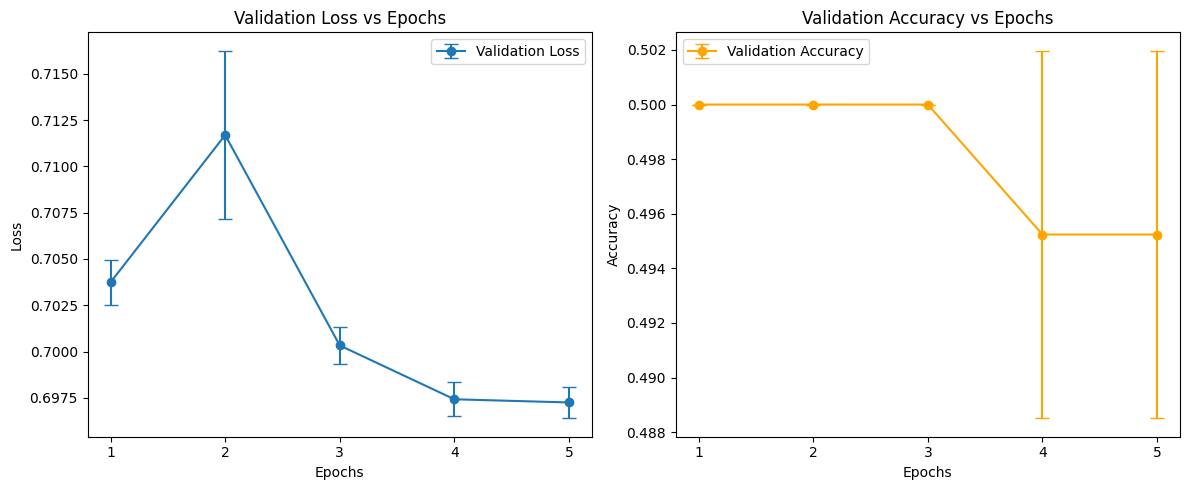

In [463]:
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments
import transformers 

accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return {"accuracy": accuracy["accuracy"]}

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
)

num_runs = 3
all_eval_losses = []
all_eval_accuracies = []

for run in range(num_runs):
    print(f"Starting run {run + 1}/{num_runs}")
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=hf_tokenizer,
        compute_metrics=compute_metrics
    )

    eval_losses = []
    eval_accuracies = []

    class CustomCallback(transformers.TrainerCallback):
        def on_epoch_end(self, args, state, control, **kwargs):
            eval_results = trainer.evaluate()
            eval_losses.append(eval_results["eval_loss"])
            eval_accuracies.append(eval_results["eval_accuracy"])

    custom_callback = CustomCallback()
    trainer.add_callback(custom_callback)

    trainer.train()

    all_eval_losses.append(eval_losses)
    all_eval_accuracies.append(eval_accuracies)

all_eval_losses = np.array(all_eval_losses)
all_eval_accuracies = np.array(all_eval_accuracies)

mean_losses = np.mean(all_eval_losses, axis=0)
std_losses = np.std(all_eval_losses, axis=0)

mean_accuracies = np.mean(all_eval_accuracies, axis=0)
std_accuracies = np.std(all_eval_accuracies, axis=0)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.errorbar(range(1, training_args.num_train_epochs + 1), mean_losses, yerr=std_losses, marker='o', label='Validation Loss', capsize=5)
plt.title('Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, training_args.num_train_epochs + 1))
plt.legend()

plt.subplot(1, 2, 2)
plt.errorbar(range(1, training_args.num_train_epochs + 1), mean_accuracies, yerr=std_accuracies, marker='o', label='Validation Accuracy', color='orange', capsize=5)
plt.title('Validation Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, training_args.num_train_epochs + 1))
plt.legend()

plt.tight_layout()
plt.show()


# Plot the red attention map

In [ ]:
from transformers import AutoTokenizer, AutoModel

fine_tuned_model_path = "./fine_tuned_model"
tokenizer = AutoTokenizer.from_pretrained(fine_tuned_model_path)
model = AutoModel.from_pretrained(fine_tuned_model_path, output_attentions=True)


In [ ]:
model.save_pretrained("./fine_tuned_model") 
tokenizer.save("/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/word_level_tokenizer.json")  

In [397]:

input_ids = test_dataset['input_ids'][0]


In [399]:
input_ids = train_dataset['input_ids'][0]

In [419]:
eval_dataset['input_ids'][0]

tensor([ 18,  13,  31,  23,  11, 135,   8,  14, 124,  40,  33,  25,  19,  13,
         27,  36,  29,  11,   8,  14,  32,  37,   5,   6,   7,   9,  28,  44,
         49,   5,   6,   7,  12,  10,  21,  15,  51,   5,   6,   7,  12,  10,
         26,  15,  42,   5,  30,  16,  34,  24,  58,  65,   5,  20,  17,  35,
         39,  22,  41, 111,   6,   7,   9,  38,  41, 110])

In [426]:
import torch
from transformers import AutoModel, PreTrainedTokenizerFast
from IPython.display import display, HTML
import matplotlib

fine_tuned_model_path = "/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/fine_tuned_model" 
tokenizer_path = "/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/word_level_tokenizer.json"  

model = AutoModel.from_pretrained(fine_tuned_model_path, output_attentions=True) 

tokenizer = PreTrainedTokenizerFast(tokenizer_file=tokenizer_path) 

input_ids = eval_dataset['input_ids'][2]  
attention_mask = eval_dataset['attention_mask'][2]  


print(f"Input IDs: {input_ids}, Type: {type(input_ids)}")
print(f"Attention Mask: {attention_mask}, Type: {type(attention_mask)}")

inputs = {
    'input_ids': input_ids.unsqueeze(0),  
    'attention_mask': attention_mask.unsqueeze(0)  
}

outputs = model(**inputs) 

mean_attention_per_token = attention.mean(dim=1)  

mean_attention_per_token = mean_attention_per_token.squeeze(0) 

cls_attention = mean_attention_per_token[1:].tolist()


max_attention = max(cls_attention)
min_attention = min(cls_attention)
normalized_attention = [(score - min_attention) / (max_attention - min_attention) for score in cls_attention]

def attention_to_color(attention_score):
    """Convert attention score to a red color intensity"""
    cmap = matplotlib.cm.get_cmap("Reds")
    rgba = cmap(attention_score)
    return matplotlib.colors.rgb2hex(rgba)

html_content = "<div style='font-size: 16px; line-height: 1.6;'>"
for word, score in zip(words, normalized_attention):
    color = attention_to_color(score)
    html_content += f"<span style='background-color: {color}; padding:2px; border-radius: 3px; margin: 1px;'>{word}</span> "
html_content += "</div>"


display(HTML(html_content))

html_filename = "attention_heatmap.html"


with open(html_filename, "w") as f:
    f.write(html_content)


Input IDs: tensor([ 18,  13,  31,  23,  11, 136,   8,  14, 117,  40,  33,  25,  19,  13,
         27,  36,  29,  11,   8,  14,  32,  37,   5,   6,   7,   9,  28,  50,
         46,   5,   6,   7,  12,  10,  21,  45,  42,   5,   6,   7,  12,  10,
         26,  15,  43,   5,  30,  16,  34,  24,  68, 116,   5,  20,  17,  35,
         39,  22,  55,  48,   6,   7,   9,  38,  55,  47]), Type: <class 'torch.Tensor'>
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), Type: <class 'torch.Tensor'>


/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_44453/636517878.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap("Reds")


## Changing the prompt

### The idea is now that we see where the attention is put, will be to try to change different prompts and plot everything together

In [2]:
from transformers import BertTokenizerFast
import re
import sqlite3


In [3]:
data_reduced_prompt = pd.read_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/data/reduced_prompt_data.csv')

NameError: name 'pd' is not defined

In [22]:
data_reduced_prompt.shape

(348, 3)

For the tokenization, let's tokenize the SMILES independently

In [28]:
conn = sqlite3.connect('cagey.db') 

cursor = conn.cursor() 

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("Tables in the database:", tables)

conn.close()

Tables in the database: [('precursors',), ('reactions',), ('nmr_spectra',), ('nmr_aldehyde_peaks',), ('nmr_imine_peaks',), ('mass_spectra',), ('mass_spectrum_peaks',), ('mass_spectrum_topology_assignments',), ('turbidity_dissolved_references',), ('turbidity_measurements',), ('turbidities',)]


In [29]:
conn = sqlite3.connect('cagey.db')

tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables_df = pd.read_sql(tables_query, conn)
table_names = tables_df['name'].tolist()

tables_dataframes = {}

for table in table_names:
    query = f"SELECT * FROM {table}"
    df = pd.read_sql(query, conn)   
    tables_dataframes[table] = df   
    print(f"Table {table} loaded successfully with {len(df)} rows.")

conn.close()


Table precursors loaded successfully with 55 rows.
Table reactions loaded successfully with 450 rows.
Table nmr_spectra loaded successfully with 449 rows.
Table nmr_aldehyde_peaks loaded successfully with 751 rows.
Table nmr_imine_peaks loaded successfully with 8897 rows.
Table mass_spectra loaded successfully with 401 rows.
Table mass_spectrum_peaks loaded successfully with 710 rows.
Table mass_spectrum_topology_assignments loaded successfully with 541 rows.
Table turbidity_dissolved_references loaded successfully with 402 rows.
Table turbidity_measurements loaded successfully with 6824 rows.
Table turbidities loaded successfully with 402 rows.


In [30]:
for table_name, df in tables_dataframes.items():
    print(f"Table: {table_name}, Type: {type(df)}")
    print(f"First value in first row: {df.iloc[0, 0]}, Type: {type(df.iloc[0, 0])}")

Table: precursors, Type: <class 'pandas.core.frame.DataFrame'>
First value in first row: Di1, Type: <class 'str'>
Table: reactions, Type: <class 'pandas.core.frame.DataFrame'>
First value in first row: 1, Type: <class 'numpy.int64'>
Table: nmr_spectra, Type: <class 'pandas.core.frame.DataFrame'>
First value in first row: 1, Type: <class 'numpy.int64'>
Table: nmr_aldehyde_peaks, Type: <class 'pandas.core.frame.DataFrame'>
First value in first row: 1, Type: <class 'numpy.int64'>
Table: nmr_imine_peaks, Type: <class 'pandas.core.frame.DataFrame'>
First value in first row: 1, Type: <class 'numpy.int64'>
Table: mass_spectra, Type: <class 'pandas.core.frame.DataFrame'>
First value in first row: 1, Type: <class 'numpy.int64'>
Table: mass_spectrum_peaks, Type: <class 'pandas.core.frame.DataFrame'>
First value in first row: 1, Type: <class 'numpy.int64'>
Table: mass_spectrum_topology_assignments, Type: <class 'pandas.core.frame.DataFrame'>
First value in first row: 1, Type: <class 'numpy.int64'

In [151]:
smiles_list = tables_dataframes['precursors']['smiles'].tolist()

In [152]:
smiles_list.append('C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)/C=C/C3=CC=C(C=C3)C=O)/C=C/C4=CC=C(C=C4)C=O)C=O')

In [153]:
target_smiles = 'NCCN(CCN)CCN'
if target_smiles in smiles_list:
    smiles_list.insert(0, smiles_list.pop(smiles_list.index(target_smiles)))

In [150]:
smiles_tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
text_tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")


In [ ]:
smiles_list

In [155]:
text_tokenizer.add_tokens(smiles_list) # we need to add the smiles into the vocab 

56

In [167]:
text_tokenizer.add_tokens(["NCCN(CCN)CCN"])

0

In [170]:
smiles_tokens = text_tokenizer("NCCN(CCN)CCN", add_special_tokens=False)["input_ids"]

print("Token IDs:", smiles_tokens)
print("Tokenized SMILES:", text_tokenizer.convert_ids_to_tokens(smiles_tokens))


Token IDs: [30522]
Tokenized SMILES: ['NCCN(CCN)CCN']


In [172]:

test_text_1 = "NCCN(CCN)CCN"
test_text_2 = "NCCN compound with NCCN(CCN)CCN structure"
print(text_tokenizer(test_text_1, add_special_tokens=False)["input_ids"])
print(text_tokenizer(test_text_2, add_special_tokens=False)["input_ids"])


[30522]
[30539, 7328, 2007, 30522, 3252]


In [156]:
print(f"Tokenizer vocabulary size after adding SMILES tokens: {len(text_tokenizer)}")

Tokenizer vocabulary size after adding SMILES tokens: 30578


In [222]:
def replace_smiles_with_placeholder(prompt, smiles_list):

    sorted_smiles_list = sorted(smiles_list, key=len, reverse=True)
    smiles_in_prompt = []
    for smiles in sorted_smiles_list:
        if smiles in prompt:
            if smiles not in smiles_in_prompt:  
                smiles_in_prompt.append(smiles)
            prompt = prompt.replace(smiles, "[SMILES]", 1)  
    return prompt, smiles_in_prompt


Working version but not for 1 smiles

In [158]:
def tokenize_prompt(prompt):
    
    text_with_placeholders, smiles_in_prompt = replace_smiles_with_placeholder(prompt, smiles_list)
    

    smiles_tokens = [text_tokenizer(smiles, add_special_tokens=False)["input_ids"] for smiles in smiles_in_prompt]
    

    text_tokens = text_tokenizer(text_with_placeholders, add_special_tokens=True, padding="max_length", truncation=True, max_length=512)
    
    combined_input_ids = []
    smiles_idx = 0
    for token_id in text_tokens["input_ids"]:
        if token_id == text_tokenizer("[SMILES]")["input_ids"][1]:  
            if smiles_idx < len(smiles_tokens):
                combined_input_ids.extend(smiles_tokens[smiles_idx])
                smiles_idx += 1
        else:
            combined_input_ids.append(token_id)
    
    combined_attention_mask = [1] * len(combined_input_ids)
    combined_attention_mask += [0] * (512 - len(combined_attention_mask))  
    combined_input_ids += [text_tokenizer.pad_token_id] * (512 - len(combined_input_ids))  

    return {
        "input_ids": combined_input_ids,
        "attention_mask": combined_attention_mask
    }


Unique placeholder

In [159]:
def tokenize_prompt(prompt, smiles_list):
    
    text_with_placeholders, smiles_in_prompt = replace_smiles_with_placeholder(prompt, smiles_list)
    
    smiles_tokens = [text_tokenizer(smiles, add_special_tokens=False)["input_ids"] for smiles in smiles_in_prompt]
   
    text_tokens = text_tokenizer(text_with_placeholders, add_special_tokens=True, padding="max_length", truncation=True, max_length=512)
    
    combined_input_ids = []
    smiles_idx = 0
    
    placeholder_token_id = text_tokenizer("[SMILES]")["input_ids"][1]

    for token_id in text_tokens["input_ids"]:
        if token_id == placeholder_token_id:  
            if smiles_idx < len(smiles_tokens):
                combined_input_ids.extend(smiles_tokens[smiles_idx])
                smiles_idx += 1  
            else:
                combined_input_ids.append(token_id)
        else:
            combined_input_ids.append(token_id)
    
    combined_attention_mask = [1] * len(combined_input_ids)
    combined_attention_mask += [0] * (512 - len(combined_attention_mask)) 
    combined_input_ids += [text_tokenizer.pad_token_id] * (512 - len(combined_input_ids))  

    return {
        "input_ids": combined_input_ids,
        "attention_mask": combined_attention_mask
    }


unique placeholder with special placeholder

In [223]:
def tokenize_prompt(prompt, smiles_list):
    special_smiles_token = "NCCN(CCN)CCN"
    special_smiles_token_id = 30522  

    text_with_placeholders, smiles_in_prompt = replace_smiles_with_placeholder(prompt, smiles_list)

    smiles_tokens = []
    
    for smiles in smiles_in_prompt:
        if smiles == special_smiles_token:
            smiles_tokens.append([special_smiles_token_id])
        else:
            smiles_tokens.append(text_tokenizer(smiles, add_special_tokens=False)["input_ids"])

    text_tokens = text_tokenizer(
        text_with_placeholders, add_special_tokens=True, padding="max_length", truncation=True, max_length=512
    )

    placeholder_token_id = text_tokenizer("[SMILES]")["input_ids"][1]
    smiles_token_id = text_tokenizer("smiles")["input_ids"][0]  
    bracket_token_id = text_tokenizer("]")["input_ids"][0]      

    combined_input_ids = []
    smiles_idx = 0

    skip_next_two_tokens = False
    for i, token_id in enumerate(text_tokens["input_ids"]):
        if skip_next_two_tokens:
            skip_next_two_tokens = False
            continue 

        if token_id == placeholder_token_id and smiles_idx < len(smiles_tokens):
    
            combined_input_ids.extend(smiles_tokens[smiles_idx])
            smiles_idx += 1
        
            if (i + 1 < len(text_tokens["input_ids"]) and text_tokens["input_ids"][i + 1] == smiles_token_id and
                i + 2 < len(text_tokens["input_ids"]) and text_tokens["input_ids"][i + 2] == bracket_token_id):
                skip_next_two_tokens = True
        else:
            combined_input_ids.append(token_id)

    combined_attention_mask = [1] * len(combined_input_ids)
    combined_attention_mask += [0] * (512 - len(combined_attention_mask))  
    combined_input_ids += [text_tokenizer.pad_token_id] * (512 - len(combined_input_ids))  

    return {
        "input_ids": combined_input_ids,
        "attention_mask": combined_attention_mask
    }


Version with ChemBERTa tokenizer

In [119]:
def tokenize_prompt(prompt):

    text_with_placeholders, smiles_in_prompt = replace_smiles_with_placeholder(prompt, smiles_list)
    
    smiles_tokens = [smiles_tokenizer(smiles, add_special_tokens=False)["input_ids"] for smiles in smiles_in_prompt]
    
    text_tokens = text_tokenizer(text_with_placeholders, add_special_tokens=True, padding="max_length", truncation=True, max_length=512)
    
    placeholder_id = text_tokenizer("[SMILES]")["input_ids"][1]  
    print(f"Identified Placeholder ID: {placeholder_id}")
    
    combined_input_ids = []
    smiles_idx = 0

    for token_id in text_tokens["input_ids"]:
        if token_id == placeholder_id:
          
            if smiles_idx < len(smiles_tokens):
                combined_input_ids.extend(smiles_tokens[smiles_idx]) 
                print(f"Inserted SMILES tokens for placeholder at index {smiles_idx}: {smiles_tokens[smiles_idx]}")
                smiles_idx += 1
            else:
                combined_input_ids.append(token_id)
        else:
            combined_input_ids.append(token_id)

    combined_input_ids = combined_input_ids[:512]
    combined_attention_mask = [1] * len(combined_input_ids)
    
    combined_input_ids += [text_tokenizer.pad_token_id] * (512 - len(combined_input_ids))
    combined_attention_mask += [0] * (512 - len(combined_attention_mask))

    return {
        "input_ids": combined_input_ids,
        "attention_mask": combined_attention_mask
    }


In [224]:
data_reduced_prompt["tokenized"] = data_reduced_prompt["Prompts"].apply(lambda prompt: tokenize_prompt(prompt, smiles_list))

print(data_reduced_prompt[["Prompts", "tokenized"]].head())


                                             Prompts  \
0  Would the mixture involving the ditopic O=Cc1c...   
1  Would the mixture involving the ditopic CC(C)(...   
2  Would the mixture involving the ditopic O=Cc1c...   
3  Would the mixture involving the ditopic O=Cc1c...   
4  Would the mixture involving the ditopic O=Cc1c...   

                                           tokenized  
0  {'input_ids': [101, 2052, 1996, 8150, 5994, 19...  
1  {'input_ids': [101, 2052, 1996, 8150, 5994, 19...  
2  {'input_ids': [101, 2052, 1996, 8150, 5994, 19...  
3  {'input_ids': [101, 2052, 1996, 8150, 5994, 19...  
4  {'input_ids': [101, 2052, 1996, 8150, 5994, 19...  


In [ ]:
data_reduced_prompt["tokenized"] = data_reduced_prompt["Prompts"].apply(tokenize_prompt)

print(data_reduced_prompt[["Prompts", "tokenized"]].head())

In [225]:
print(data_reduced_prompt["tokenized"].iloc[79])


{'input_ids': [101, 2052, 1996, 8150, 5994, 1996, 4487, 14399, 2594, 30538, 8451, 1033, 1998, 13012, 14399, 2594, 30560, 8451, 1033, 2311, 5991, 2022, 10722, 15185, 3593, 2030, 8314, 1029, 4209, 1996, 2206, 17678, 13465, 3111, 2055, 2068, 1024, 1996, 2193, 1997, 25496, 2967, 1999, 1996, 4487, 14399, 2594, 28699, 2666, 2003, 1015, 1998, 1997, 1996, 13012, 14399, 2594, 28699, 2666, 2003, 1014, 1012, 1996, 2193, 1997, 9732, 5416, 5138, 5668, 1999, 1996, 4487, 14399, 2594, 28699, 2666, 2003, 1018, 1998, 1997, 1996, 13012, 14399, 2594, 28699, 2666, 2003, 1018, 1012, 1014, 1012, 1996, 2193, 1997, 9732, 5416, 2123, 12131, 1999, 1996, 4487, 14399, 2594, 28699, 2666, 2003, 1014, 1998, 1997, 1996, 13012, 14399, 2594, 28699, 2666, 2003, 1017, 1012, 1014, 1012, 1996, 2193, 1997, 3082, 13353, 1999, 1996, 4487, 14399, 2594, 28699, 2666, 2003, 2538, 1998, 1997, 1996, 13012, 14399, 2594, 28699, 2666, 2003, 2410, 1012, 1014, 1012, 1996, 8833, 2361, 1006, 13323, 6761, 2140, 1013, 2300, 13571, 19064, 100

In [226]:
first_input_ids = data_reduced_prompt["tokenized"].iloc[79]["input_ids"]
decoded_tokens = text_tokenizer.convert_ids_to_tokens(first_input_ids)
print(decoded_tokens)

['[CLS]', 'would', 'the', 'mixture', 'involving', 'the', 'di', '##top', '##ic', 'CCCCC(CC)COc1cc(C=O)c(OC)cc1C=O', 'smiles', ']', 'and', 'tri', '##top', '##ic', 'NCCCN(CCCN)CCCN', 'smiles', ']', 'building', 'blocks', 'be', 'tu', '##rb', '##id', 'or', 'dissolved', '?', 'knowing', 'the', 'following', 'prop', '##ret', '##ies', 'about', 'them', ':', 'the', 'number', 'of', 'aromatic', 'groups', 'in', 'the', 'di', '##top', '##ic', 'spec', '##ie', 'is', '1', 'and', 'of', 'the', 'tri', '##top', '##ic', 'spec', '##ie', 'is', '0', '.', 'the', 'number', 'of', 'hydrogen', 'bond', 'accept', '##ors', 'in', 'the', 'di', '##top', '##ic', 'spec', '##ie', 'is', '4', 'and', 'of', 'the', 'tri', '##top', '##ic', 'spec', '##ie', 'is', '4', '.', '0', '.', 'the', 'number', 'of', 'hydrogen', 'bond', 'don', '##nor', 'in', 'the', 'di', '##top', '##ic', 'spec', '##ie', 'is', '0', 'and', 'of', 'the', 'tri', '##top', '##ic', 'spec', '##ie', 'is', '3', '.', '0', '.', 'the', 'number', 'of', 'heavy', 'atoms', 'in', 't

In [227]:
def decode_input_ids(row):
    input_ids = row["tokenized"]["input_ids"]
    decoded_tokens = text_tokenizer.convert_ids_to_tokens(input_ids)
    return decoded_tokens

data_reduced_prompt["decoded_tokens"] = data_reduced_prompt.apply(decode_input_ids, axis=1)


In [228]:
data_reduced_prompt.to_csv('/Users/davidsegura/Desktop/controlling_tokenization.csv')

### Training BERT model

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

In [278]:
#model_name = "seyonec/ChemBERTa_zinc250k_v2_40k"
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [279]:
data_reduced_prompt

,Unnamed: 0,Prompts,turbidity,tokenized,decoded_tokens,input_ids,attention_mask,labels
0,0,Would the mixture involving the ditopic O=Cc1c...,0,"{'input_ids': [101, 2052, 1996, 8150, 5994, 19...","[[CLS], would, the, mixture, involving, the, d...","[101, 2052, 1996, 8150, 5994, 1996, 4487, 1439...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
1,1,Would the mixture involving the ditopic CC(C)(...,0,"{'input_ids': [101, 2052, 1996, 8150, 5994, 19...","[[CLS], would, the, mixture, involving, the, d...","[101, 2052, 1996, 8150, 5994, 1996, 4487, 1439...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
2,2,Would the mixture involving the ditopic O=Cc1c...,0,"{'input_ids': [101, 2052, 1996, 8150, 5994, 19...","[[CLS], would, the, mixture, involving, the, d...","[101, 2052, 1996, 8150, 5994, 1996, 4487, 1439...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
3,3,Would the mixture involving the ditopic O=Cc1c...,0,"{'input_ids': [101, 2052, 1996, 8150, 5994, 19...","[[CLS], would, the, mixture, involving, the, d...","[101, 2052, 1996, 8150, 5994, 1996, 4487, 1439...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
4,4,Would the mixture involving the ditopic O=Cc1c...,0,"{'input_ids': [101, 2052, 1996, 8150, 5994, 19...","[[CLS], would, the, mixture, involving, the, d...","[101, 2052, 1996, 8150, 5994, 1996, 4487, 1439...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
...,...,...,...,...,...,...,...,...
343,343,Would the mixture involving the ditopic NCCOCC...,1,"{'input_ids': [101, 2052, 1996, 8150, 5994, 19...","[[CLS], would, the, mixture, involving, the, d...","[101, 2052, 1996, 8150, 5994, 1996, 4487, 1439...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
344,344,Would the mixture involving the ditopic NCC1=C...,1,"{'input_ids': [101, 2052, 1996, 8150, 5994, 19...","[[CLS], would, the, mixture, involving, the, d...","[101, 2052, 1996, 8150, 5994, 1996, 4487, 1439...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
345,345,Would the mixture involving the ditopic NCC(CN...,1,"{'input_ids': [101, 2052, 1996, 8150, 5994, 19...","[[CLS], would, the, mixture, involving, the, d...","[101, 2052, 1996, 8150, 5994, 1996, 4487, 1439...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
346,346,Would the mixture involving the ditopic NCCCC[...,1,"{'input_ids': [101, 2052, 1996, 8150, 5994, 19...","[[CLS], would, the, mixture, involving, the, d...","[101, 2052, 1996, 8150, 5994, 1996, 4487, 1439...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1


In [281]:
data_reduced_prompt["input_ids"] = data_reduced_prompt["tokenized"].apply(lambda x: x["input_ids"])
data_reduced_prompt["attention_mask"] = data_reduced_prompt["tokenized"].apply(lambda x: x["attention_mask"])
data_reduced_prompt["labels"] = data_reduced_prompt["turbidity"] 

dataset = Dataset.from_pandas(data_reduced_prompt[["input_ids", "attention_mask", "labels"]])

train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    learning_rate=5e-5,
    save_steps=10_000,
    save_total_limit=2,
    logging_steps=50 
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,  
)



/Users/davidsegura/miniconda3/envs/env_cage/lib/python3.9/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [282]:
trainer.train()

eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")



  0%|          | 0/350 [00:00<?, ?it/s]

{'loss': 0.7278, 'grad_norm': 8.420694351196289, 'learning_rate': 4.2857142857142856e-05, 'epoch': 0.71}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.7066532373428345, 'eval_accuracy': 0.5142857142857142, 'eval_runtime': 15.9122, 'eval_samples_per_second': 4.399, 'eval_steps_per_second': 1.131, 'epoch': 1.0}
{'loss': 0.7075, 'grad_norm': 9.770400047302246, 'learning_rate': 3.571428571428572e-05, 'epoch': 1.43}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.7180407047271729, 'eval_accuracy': 0.5142857142857142, 'eval_runtime': 16.5737, 'eval_samples_per_second': 4.224, 'eval_steps_per_second': 1.086, 'epoch': 2.0}
{'loss': 0.7033, 'grad_norm': 5.198792457580566, 'learning_rate': 2.857142857142857e-05, 'epoch': 2.14}
{'loss': 0.7183, 'grad_norm': 3.5309085845947266, 'learning_rate': 2.1428571428571428e-05, 'epoch': 2.86}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.6927423477172852, 'eval_accuracy': 0.5142857142857142, 'eval_runtime': 15.5781, 'eval_samples_per_second': 4.493, 'eval_steps_per_second': 1.155, 'epoch': 3.0}
{'loss': 0.6919, 'grad_norm': 9.438436508178711, 'learning_rate': 1.4285714285714285e-05, 'epoch': 3.57}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.6940053701400757, 'eval_accuracy': 0.4857142857142857, 'eval_runtime': 15.8381, 'eval_samples_per_second': 4.42, 'eval_steps_per_second': 1.137, 'epoch': 4.0}
{'loss': 0.7003, 'grad_norm': 2.5781233310699463, 'learning_rate': 7.142857142857143e-06, 'epoch': 4.29}
{'loss': 0.6868, 'grad_norm': 16.79537010192871, 'learning_rate': 0.0, 'epoch': 5.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.6927961111068726, 'eval_accuracy': 0.5142857142857142, 'eval_runtime': 16.7298, 'eval_samples_per_second': 4.184, 'eval_steps_per_second': 1.076, 'epoch': 5.0}
{'train_runtime': 1141.0199, 'train_samples_per_second': 1.218, 'train_steps_per_second': 0.307, 'train_loss': 0.7051299285888671, 'epoch': 5.0}


  0%|          | 0/18 [00:00<?, ?it/s]

Evaluation Results: {'eval_loss': 0.6927961111068726, 'eval_accuracy': 0.5142857142857142, 'eval_runtime': 24.9222, 'eval_samples_per_second': 2.809, 'eval_steps_per_second': 0.722, 'epoch': 5.0}


In [240]:
#model.save_pretrained("./turbidity_model")
#tokenizer.save_pretrained("./turbidity_model")


('./turbidity_model/tokenizer_config.json',
 './turbidity_model/special_tokens_map.json',
 './turbidity_model/vocab.json',
 './turbidity_model/merges.txt',
 './turbidity_model/added_tokens.json',
 './turbidity_model/tokenizer.json')

In [283]:
predictions = trainer.predict(eval_dataset)  

preds = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

  0%|          | 0/18 [00:00<?, ?it/s]

In [284]:
preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [245]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve

In [247]:
import matplotlib.pyplot as plt

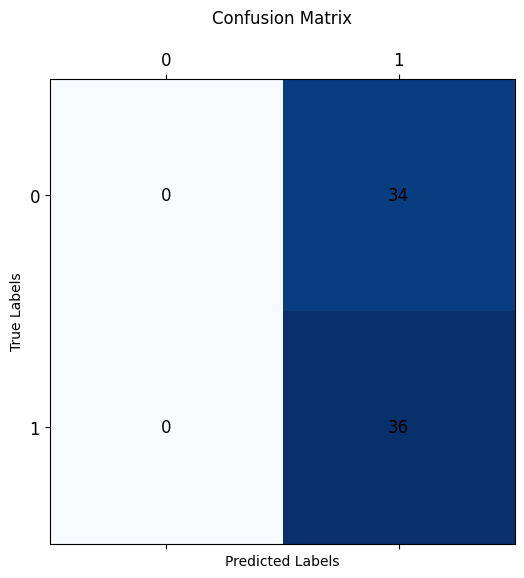

In [252]:
cm = confusion_matrix(true_labels, preds)

plt.figure(figsize=(6, 6))
plt.matshow(cm, cmap='Blues', fignum=1)

plt.title('Confusion Matrix', pad=20)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{cm[i, j]:d}', ha='center', va='center', color='black', fontsize=12)

plt.xticks([0, 1], ['0', '1'], fontsize=12)
plt.yticks([0, 1], ['0', '1'], fontsize=12)

plt.show()


# New approach with ChemBERTa


Let's try only with the SMILES

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
data_reduced_chemberta = pd.read_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/data/reduced_dataset_turbidity.csv')

In [10]:
data_reduced_chemberta = data_reduced_chemberta[['di_smiles', 'tri_smiles', 'turbidity_binary']]

In [11]:
data_reduced_chemberta["combined_smiles"] = data_reduced_chemberta["di_smiles"] + " [SEP] " + data_reduced_chemberta["tri_smiles"]


In [40]:
repeated_smiles = data_reduced_chemberta[data_reduced_chemberta.duplicated(subset="combined_smiles", keep=False)]
repeated_smiles

,di_smiles,tri_smiles,turbidity_binary,combined_smiles


In [12]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data_reduced_chemberta["combined_smiles"].tolist(), data_reduced_chemberta["turbidity_binary"].tolist(), test_size=0.2, random_state=42
)

In [13]:
model_name = "seyonec/ChemBERTa_zinc250k_v2_40k"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa_zinc250k_v2_40k and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors="pt")
val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors="pt")

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

class SmilesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SmilesDataset(train_encodings, train_labels)
val_dataset = SmilesDataset(val_encodings, val_labels)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',  
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/Users/davidsegura/miniconda3/envs/env_cage/lib/python3.9/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/105 [00:00<?, ?it/s]

{'loss': 0.7179, 'grad_norm': 7.24699068069458, 'learning_rate': 4.523809523809524e-05, 'epoch': 0.29}
{'loss': 0.5862, 'grad_norm': 9.065000534057617, 'learning_rate': 4.047619047619048e-05, 'epoch': 0.57}
{'loss': 0.6183, 'grad_norm': 9.539673805236816, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.86}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.5933039784431458, 'eval_runtime': 2.8721, 'eval_samples_per_second': 24.373, 'eval_steps_per_second': 3.134, 'epoch': 1.0}
{'loss': 0.4832, 'grad_norm': 4.772195816040039, 'learning_rate': 3.095238095238095e-05, 'epoch': 1.14}
{'loss': 0.4544, 'grad_norm': 9.763381004333496, 'learning_rate': 2.6190476190476192e-05, 'epoch': 1.43}
{'loss': 0.4057, 'grad_norm': 6.581486225128174, 'learning_rate': 2.1428571428571428e-05, 'epoch': 1.71}
{'loss': 0.4814, 'grad_norm': 5.549365520477295, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.5766083598136902, 'eval_runtime': 0.9574, 'eval_samples_per_second': 73.111, 'eval_steps_per_second': 9.4, 'epoch': 2.0}
{'loss': 0.2525, 'grad_norm': 3.5218069553375244, 'learning_rate': 1.1904761904761905e-05, 'epoch': 2.29}
{'loss': 0.3286, 'grad_norm': 2.909175395965576, 'learning_rate': 7.142857142857143e-06, 'epoch': 2.57}
{'loss': 0.3092, 'grad_norm': 4.805489540100098, 'learning_rate': 2.3809523809523808e-06, 'epoch': 2.86}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.5697126388549805, 'eval_runtime': 0.7734, 'eval_samples_per_second': 90.513, 'eval_steps_per_second': 11.637, 'epoch': 3.0}
{'train_runtime': 83.4817, 'train_samples_per_second': 9.99, 'train_steps_per_second': 1.258, 'train_loss': 0.45580055373055595, 'epoch': 3.0}


TrainOutput(global_step=105, training_loss=0.45580055373055595, metrics={'train_runtime': 83.4817, 'train_samples_per_second': 9.99, 'train_steps_per_second': 1.258, 'total_flos': 23088136174344.0, 'train_loss': 0.45580055373055595, 'epoch': 3.0})

In [15]:
eval_results = trainer.evaluate(val_dataset)
print(eval_results) 

  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.5697126388549805, 'eval_runtime': 0.538, 'eval_samples_per_second': 130.101, 'eval_steps_per_second': 16.727, 'epoch': 3.0}


In [16]:
predictions_output = trainer.predict(val_dataset)

  0%|          | 0/9 [00:00<?, ?it/s]

In [17]:
pred_labels = torch.argmax(torch.tensor(predictions_output.predictions), axis=1).numpy()

true_labels = predictions_output.label_ids

In [18]:
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.81


## Testing on the test set directly

In [21]:
from transformers import Trainer, TrainingArguments

train_texts, test_texts, train_labels, test_labels = train_test_split(
    data_reduced_chemberta["combined_smiles"].tolist(),
    data_reduced_chemberta["turbidity_binary"].tolist(),
    test_size=0.2,  
    random_state=42
)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors="pt")

train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

class SmilesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SmilesDataset(train_encodings, train_labels)
test_dataset = SmilesDataset(test_encodings, test_labels)

training_args = TrainingArguments(
    output_dir="./results",      
    evaluation_strategy="no",   
    per_device_train_batch_size=8,  
    num_train_epochs=3,           
    weight_decay=0.01,            
    logging_dir='./logs',        
    logging_steps=10,             
)

from sklearn.metrics import accuracy_score
from transformers import Trainer, TrainingArguments

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)  
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    compute_metrics=compute_metrics, 
)

trainer.train()

test_results = trainer.evaluate(test_dataset)
print(f"Test Results: {test_results}")



/Users/davidsegura/miniconda3/envs/env_cage/lib/python3.9/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/105 [00:00<?, ?it/s]

{'loss': 0.0295, 'grad_norm': 0.13865633308887482, 'learning_rate': 4.523809523809524e-05, 'epoch': 0.29}
{'loss': 0.3617, 'grad_norm': 11.982073783874512, 'learning_rate': 4.047619047619048e-05, 'epoch': 0.57}
{'loss': 0.2045, 'grad_norm': 25.152088165283203, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.86}
{'loss': 0.0923, 'grad_norm': 1.7653474807739258, 'learning_rate': 3.095238095238095e-05, 'epoch': 1.14}
{'loss': 0.2117, 'grad_norm': 18.127443313598633, 'learning_rate': 2.6190476190476192e-05, 'epoch': 1.43}
{'loss': 0.1183, 'grad_norm': 0.41930922865867615, 'learning_rate': 2.1428571428571428e-05, 'epoch': 1.71}
{'loss': 0.0983, 'grad_norm': 0.4719413220882416, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}
{'loss': 0.204, 'grad_norm': 2.3866264820098877, 'learning_rate': 1.1904761904761905e-05, 'epoch': 2.29}
{'loss': 0.2081, 'grad_norm': 0.18496838212013245, 'learning_rate': 7.142857142857143e-06, 'epoch': 2.57}
{'loss': 0.1187, 'grad_norm': 0.6120941042900085, 

  0%|          | 0/9 [00:00<?, ?it/s]

Test Results: {'eval_loss': 1.0084301233291626, 'eval_accuracy': 0.8285714285714286, 'eval_runtime': 0.7248, 'eval_samples_per_second': 96.578, 'eval_steps_per_second': 12.417, 'epoch': 3.0}


## Testing to plot over multiple epochs


Run 1/3

Training for 1 epoch(s)...


  0%|          | 0/35 [00:00<?, ?it/s]

{'loss': 0.7121, 'grad_norm': 7.369133472442627, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.29}
{'loss': 0.6236, 'grad_norm': 10.151750564575195, 'learning_rate': 2.1428571428571428e-05, 'epoch': 0.57}
{'loss': 0.6038, 'grad_norm': 5.403231143951416, 'learning_rate': 7.142857142857143e-06, 'epoch': 0.86}
{'train_runtime': 21.2771, 'train_samples_per_second': 13.066, 'train_steps_per_second': 1.645, 'train_loss': 0.6361634867531912, 'epoch': 1.0}
Test Accuracy after training for 1 epoch(s): 0.6571

Training for 2 epoch(s)...


  0%|          | 0/70 [00:00<?, ?it/s]

{'loss': 0.509, 'grad_norm': 6.80057954788208, 'learning_rate': 4.2857142857142856e-05, 'epoch': 0.29}
{'loss': 0.4803, 'grad_norm': 9.533134460449219, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.57}
{'loss': 0.4494, 'grad_norm': 10.334773063659668, 'learning_rate': 2.857142857142857e-05, 'epoch': 0.86}
{'loss': 0.3483, 'grad_norm': 5.141994953155518, 'learning_rate': 2.1428571428571428e-05, 'epoch': 1.14}
{'loss': 0.4823, 'grad_norm': 13.047527313232422, 'learning_rate': 1.4285714285714285e-05, 'epoch': 1.43}
{'loss': 0.3098, 'grad_norm': 4.476320266723633, 'learning_rate': 7.142857142857143e-06, 'epoch': 1.71}
{'loss': 0.3161, 'grad_norm': 4.203855991363525, 'learning_rate': 0.0, 'epoch': 2.0}
{'train_runtime': 37.9585, 'train_samples_per_second': 14.648, 'train_steps_per_second': 1.844, 'train_loss': 0.41359308787754606, 'epoch': 2.0}
Test Accuracy after training for 2 epoch(s): 0.7857

Training for 3 epoch(s)...


  0%|          | 0/105 [00:00<?, ?it/s]

{'loss': 0.2906, 'grad_norm': 4.267680644989014, 'learning_rate': 4.523809523809524e-05, 'epoch': 0.29}
{'loss': 0.4323, 'grad_norm': 5.743842124938965, 'learning_rate': 4.047619047619048e-05, 'epoch': 0.57}
{'loss': 0.4256, 'grad_norm': 10.88731861114502, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.86}
{'loss': 0.2114, 'grad_norm': 6.414273738861084, 'learning_rate': 3.095238095238095e-05, 'epoch': 1.14}
{'loss': 0.341, 'grad_norm': 14.826025009155273, 'learning_rate': 2.6190476190476192e-05, 'epoch': 1.43}
{'loss': 0.2707, 'grad_norm': 3.969646692276001, 'learning_rate': 2.1428571428571428e-05, 'epoch': 1.71}
{'loss': 0.1972, 'grad_norm': 5.136298179626465, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}
{'loss': 0.1597, 'grad_norm': 1.5423660278320312, 'learning_rate': 1.1904761904761905e-05, 'epoch': 2.29}
{'loss': 0.1595, 'grad_norm': 1.7918949127197266, 'learning_rate': 7.142857142857143e-06, 'epoch': 2.57}
{'loss': 0.1665, 'grad_norm': 7.418068885803223, 'learning_

  0%|          | 0/140 [00:00<?, ?it/s]

{'loss': 0.0814, 'grad_norm': 6.829556941986084, 'learning_rate': 4.642857142857143e-05, 'epoch': 0.29}
{'loss': 0.4381, 'grad_norm': 0.18082696199417114, 'learning_rate': 4.2857142857142856e-05, 'epoch': 0.57}
{'loss': 0.3762, 'grad_norm': 9.677021980285645, 'learning_rate': 3.928571428571429e-05, 'epoch': 0.86}
{'loss': 0.1871, 'grad_norm': 3.48280668258667, 'learning_rate': 3.571428571428572e-05, 'epoch': 1.14}
{'loss': 0.2107, 'grad_norm': 19.36344337463379, 'learning_rate': 3.2142857142857144e-05, 'epoch': 1.43}
{'loss': 0.3137, 'grad_norm': 24.07204246520996, 'learning_rate': 2.857142857142857e-05, 'epoch': 1.71}
{'loss': 0.1646, 'grad_norm': 4.306484699249268, 'learning_rate': 2.5e-05, 'epoch': 2.0}
{'loss': 0.1757, 'grad_norm': 0.5810405015945435, 'learning_rate': 2.1428571428571428e-05, 'epoch': 2.29}
{'loss': 0.0923, 'grad_norm': 0.3181250989437103, 'learning_rate': 1.785714285714286e-05, 'epoch': 2.57}
{'loss': 0.1655, 'grad_norm': 4.544318199157715, 'learning_rate': 1.42857

  0%|          | 0/175 [00:00<?, ?it/s]

{'loss': 0.0121, 'grad_norm': 1.0574665069580078, 'learning_rate': 4.714285714285714e-05, 'epoch': 0.29}
{'loss': 0.3014, 'grad_norm': 4.383674621582031, 'learning_rate': 4.428571428571428e-05, 'epoch': 0.57}
{'loss': 0.2116, 'grad_norm': 15.841099739074707, 'learning_rate': 4.1428571428571437e-05, 'epoch': 0.86}
{'loss': 0.0909, 'grad_norm': 0.16751305758953094, 'learning_rate': 3.857142857142858e-05, 'epoch': 1.14}
{'loss': 0.163, 'grad_norm': 17.553388595581055, 'learning_rate': 3.571428571428572e-05, 'epoch': 1.43}
{'loss': 0.1553, 'grad_norm': 0.2640017569065094, 'learning_rate': 3.285714285714286e-05, 'epoch': 1.71}
{'loss': 0.0406, 'grad_norm': 23.017484664916992, 'learning_rate': 3e-05, 'epoch': 2.0}
{'loss': 0.1495, 'grad_norm': 0.018257202580571175, 'learning_rate': 2.714285714285714e-05, 'epoch': 2.29}
{'loss': 0.0102, 'grad_norm': 0.04051189869642258, 'learning_rate': 2.4285714285714288e-05, 'epoch': 2.57}
{'loss': 0.0331, 'grad_norm': 0.058483950793743134, 'learning_rate':

  0%|          | 0/35 [00:00<?, ?it/s]

{'loss': 0.0105, 'grad_norm': 0.005073431879281998, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.29}
{'loss': 0.1172, 'grad_norm': 0.6023678779602051, 'learning_rate': 2.1428571428571428e-05, 'epoch': 0.57}
{'loss': 0.1441, 'grad_norm': 0.12563183903694153, 'learning_rate': 7.142857142857143e-06, 'epoch': 0.86}
{'train_runtime': 17.5632, 'train_samples_per_second': 15.829, 'train_steps_per_second': 1.993, 'train_loss': 0.12258148831980568, 'epoch': 1.0}
Test Accuracy after training for 1 epoch(s): 0.8143

Training for 2 epoch(s)...


  0%|          | 0/70 [00:00<?, ?it/s]

{'loss': 0.0651, 'grad_norm': 55.97486114501953, 'learning_rate': 4.2857142857142856e-05, 'epoch': 0.29}
{'loss': 0.0779, 'grad_norm': 0.00594830047339201, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.57}
{'loss': 0.1284, 'grad_norm': 0.0031827169004827738, 'learning_rate': 2.857142857142857e-05, 'epoch': 0.86}
{'loss': 0.0414, 'grad_norm': 0.6342776417732239, 'learning_rate': 2.1428571428571428e-05, 'epoch': 1.14}
{'loss': 0.0117, 'grad_norm': 14.657037734985352, 'learning_rate': 1.4285714285714285e-05, 'epoch': 1.43}
{'loss': 0.1294, 'grad_norm': 0.01062250416725874, 'learning_rate': 7.142857142857143e-06, 'epoch': 1.71}
{'loss': 0.0025, 'grad_norm': 0.005605084355920553, 'learning_rate': 0.0, 'epoch': 2.0}
{'train_runtime': 35.4298, 'train_samples_per_second': 15.693, 'train_steps_per_second': 1.976, 'train_loss': 0.06518567757947104, 'epoch': 2.0}
Test Accuracy after training for 2 epoch(s): 0.8429

Training for 3 epoch(s)...


  0%|          | 0/105 [00:00<?, ?it/s]

{'loss': 0.0006, 'grad_norm': 0.024675415828824043, 'learning_rate': 4.523809523809524e-05, 'epoch': 0.29}
{'loss': 0.0186, 'grad_norm': 0.0009520270978100598, 'learning_rate': 4.047619047619048e-05, 'epoch': 0.57}
{'loss': 0.002, 'grad_norm': 1.133359432220459, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.86}
{'loss': 0.0181, 'grad_norm': 35.404998779296875, 'learning_rate': 3.095238095238095e-05, 'epoch': 1.14}
{'loss': 0.2581, 'grad_norm': 24.26204490661621, 'learning_rate': 2.6190476190476192e-05, 'epoch': 1.43}
{'loss': 0.071, 'grad_norm': 0.0006763080018572509, 'learning_rate': 2.1428571428571428e-05, 'epoch': 1.71}
{'loss': 0.0561, 'grad_norm': 0.0026681963354349136, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}
{'loss': 0.0121, 'grad_norm': 0.011632813140749931, 'learning_rate': 1.1904761904761905e-05, 'epoch': 2.29}
{'loss': 0.0004, 'grad_norm': 0.003909499384462833, 'learning_rate': 7.142857142857143e-06, 'epoch': 2.57}
{'loss': 0.0001, 'grad_norm': 0.007024399

  0%|          | 0/140 [00:00<?, ?it/s]

{'loss': 0.0001, 'grad_norm': 0.001383423455990851, 'learning_rate': 4.642857142857143e-05, 'epoch': 0.29}
{'loss': 0.0002, 'grad_norm': 0.0006374146323651075, 'learning_rate': 4.2857142857142856e-05, 'epoch': 0.57}
{'loss': 0.0002, 'grad_norm': 0.00046867268974892795, 'learning_rate': 3.928571428571429e-05, 'epoch': 0.86}
{'loss': 0.0004, 'grad_norm': 0.00029488318250514567, 'learning_rate': 3.571428571428572e-05, 'epoch': 1.14}
{'loss': 0.0001, 'grad_norm': 0.10666494816541672, 'learning_rate': 3.2142857142857144e-05, 'epoch': 1.43}
{'loss': 0.0797, 'grad_norm': 0.016283927485346794, 'learning_rate': 2.857142857142857e-05, 'epoch': 1.71}
{'loss': 0.0001, 'grad_norm': 0.011774781160056591, 'learning_rate': 2.5e-05, 'epoch': 2.0}
{'loss': 0.0007, 'grad_norm': 0.01206905860453844, 'learning_rate': 2.1428571428571428e-05, 'epoch': 2.29}
{'loss': 0.0001, 'grad_norm': 0.018093476071953773, 'learning_rate': 1.785714285714286e-05, 'epoch': 2.57}
{'loss': 0.0004, 'grad_norm': 0.00115363171789

  0%|          | 0/175 [00:00<?, ?it/s]

{'loss': 0.0003, 'grad_norm': 0.0002907076559495181, 'learning_rate': 4.714285714285714e-05, 'epoch': 0.29}
{'loss': 0.0003, 'grad_norm': 0.00020666232740040869, 'learning_rate': 4.428571428571428e-05, 'epoch': 0.57}
{'loss': 0.2098, 'grad_norm': 0.003146644216030836, 'learning_rate': 4.1428571428571437e-05, 'epoch': 0.86}
{'loss': 0.0794, 'grad_norm': 0.35038653016090393, 'learning_rate': 3.857142857142858e-05, 'epoch': 1.14}
{'loss': 0.237, 'grad_norm': 0.8492893576622009, 'learning_rate': 3.571428571428572e-05, 'epoch': 1.43}
{'loss': 0.0607, 'grad_norm': 40.387577056884766, 'learning_rate': 3.285714285714286e-05, 'epoch': 1.71}
{'loss': 0.0557, 'grad_norm': 0.10104157775640488, 'learning_rate': 3e-05, 'epoch': 2.0}
{'loss': 0.0775, 'grad_norm': 0.007288145367056131, 'learning_rate': 2.714285714285714e-05, 'epoch': 2.29}
{'loss': 0.0093, 'grad_norm': 19.677143096923828, 'learning_rate': 2.4285714285714288e-05, 'epoch': 2.57}
{'loss': 0.0025, 'grad_norm': 0.005521073006093502, 'learn

  0%|          | 0/35 [00:00<?, ?it/s]

{'loss': 0.0, 'grad_norm': 3.898846989613958e-05, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.29}
{'loss': 0.1302, 'grad_norm': 2.4590945031377487e-05, 'learning_rate': 2.1428571428571428e-05, 'epoch': 0.57}
{'loss': 0.0293, 'grad_norm': 8.932725177146494e-05, 'learning_rate': 7.142857142857143e-06, 'epoch': 0.86}
{'train_runtime': 17.7162, 'train_samples_per_second': 15.692, 'train_steps_per_second': 1.976, 'train_loss': 0.062326590493674824, 'epoch': 1.0}
Test Accuracy after training for 1 epoch(s): 0.8143

Training for 2 epoch(s)...


  0%|          | 0/70 [00:00<?, ?it/s]

{'loss': 0.0003, 'grad_norm': 2.5122621082118712e-05, 'learning_rate': 4.2857142857142856e-05, 'epoch': 0.29}
{'loss': 0.164, 'grad_norm': 0.15091410279273987, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.57}
{'loss': 0.1945, 'grad_norm': 0.00018003133300226182, 'learning_rate': 2.857142857142857e-05, 'epoch': 0.86}
{'loss': 0.0823, 'grad_norm': 7.644577272003517e-05, 'learning_rate': 2.1428571428571428e-05, 'epoch': 1.14}
{'loss': 0.0114, 'grad_norm': 35.302215576171875, 'learning_rate': 1.4285714285714285e-05, 'epoch': 1.43}
{'loss': 0.0873, 'grad_norm': 0.5108574032783508, 'learning_rate': 7.142857142857143e-06, 'epoch': 1.71}
{'loss': 0.0657, 'grad_norm': 8.099638944258913e-05, 'learning_rate': 0.0, 'epoch': 2.0}
{'train_runtime': 35.3146, 'train_samples_per_second': 15.744, 'train_steps_per_second': 1.982, 'train_loss': 0.08648975047815059, 'epoch': 2.0}
Test Accuracy after training for 2 epoch(s): 0.8143

Training for 3 epoch(s)...


  0%|          | 0/105 [00:00<?, ?it/s]

{'loss': 0.0052, 'grad_norm': 0.001067570992745459, 'learning_rate': 4.523809523809524e-05, 'epoch': 0.29}
{'loss': 0.0001, 'grad_norm': 0.0002446887083351612, 'learning_rate': 4.047619047619048e-05, 'epoch': 0.57}
{'loss': 0.0, 'grad_norm': 0.00018670374993234873, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.86}
{'loss': 0.0, 'grad_norm': 0.0313526913523674, 'learning_rate': 3.095238095238095e-05, 'epoch': 1.14}
{'loss': 0.0001, 'grad_norm': 0.049708351492881775, 'learning_rate': 2.6190476190476192e-05, 'epoch': 1.43}
{'loss': 0.0, 'grad_norm': 0.0012953110272064805, 'learning_rate': 2.1428571428571428e-05, 'epoch': 1.71}
{'loss': 0.0, 'grad_norm': 0.00010316803673049435, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}
{'loss': 0.0, 'grad_norm': 0.0017769482219591737, 'learning_rate': 1.1904761904761905e-05, 'epoch': 2.29}
{'loss': 0.0, 'grad_norm': 9.460236469749361e-05, 'learning_rate': 7.142857142857143e-06, 'epoch': 2.57}
{'loss': 0.0, 'grad_norm': 0.00278656254522502

  0%|          | 0/140 [00:00<?, ?it/s]

{'loss': 0.0, 'grad_norm': 0.00011413684114813805, 'learning_rate': 4.642857142857143e-05, 'epoch': 0.29}
{'loss': 0.0, 'grad_norm': 9.753982885740697e-05, 'learning_rate': 4.2857142857142856e-05, 'epoch': 0.57}
{'loss': 0.0, 'grad_norm': 9.529903763905168e-05, 'learning_rate': 3.928571428571429e-05, 'epoch': 0.86}
{'loss': 0.0, 'grad_norm': 6.109768582973629e-05, 'learning_rate': 3.571428571428572e-05, 'epoch': 1.14}
{'loss': 0.0, 'grad_norm': 0.0027038571424782276, 'learning_rate': 3.2142857142857144e-05, 'epoch': 1.43}
{'loss': 0.0, 'grad_norm': 0.002158466260880232, 'learning_rate': 2.857142857142857e-05, 'epoch': 1.71}
{'loss': 0.0, 'grad_norm': 0.00018690408614929765, 'learning_rate': 2.5e-05, 'epoch': 2.0}
{'loss': 0.0, 'grad_norm': 0.00032395950984209776, 'learning_rate': 2.1428571428571428e-05, 'epoch': 2.29}
{'loss': 0.0, 'grad_norm': 0.0006689006695523858, 'learning_rate': 1.785714285714286e-05, 'epoch': 2.57}
{'loss': 0.0, 'grad_norm': 0.0039035282097756863, 'learning_rate'

  0%|          | 0/175 [00:00<?, ?it/s]

{'loss': 0.0, 'grad_norm': 5.6179589591920376e-05, 'learning_rate': 4.714285714285714e-05, 'epoch': 0.29}
{'loss': 0.0151, 'grad_norm': 0.00019481555500533432, 'learning_rate': 4.428571428571428e-05, 'epoch': 0.57}
{'loss': 0.1832, 'grad_norm': 0.00017834494065027684, 'learning_rate': 4.1428571428571437e-05, 'epoch': 0.86}
{'loss': 0.128, 'grad_norm': 0.03142617642879486, 'learning_rate': 3.857142857142858e-05, 'epoch': 1.14}
{'loss': 0.2771, 'grad_norm': 8.815767288208008, 'learning_rate': 3.571428571428572e-05, 'epoch': 1.43}
{'loss': 0.0987, 'grad_norm': 35.525474548339844, 'learning_rate': 3.285714285714286e-05, 'epoch': 1.71}
{'loss': 0.1749, 'grad_norm': 55.20458984375, 'learning_rate': 3e-05, 'epoch': 2.0}
{'loss': 0.1652, 'grad_norm': 0.028690040111541748, 'learning_rate': 2.714285714285714e-05, 'epoch': 2.29}
{'loss': 0.237, 'grad_norm': 8.058327674865723, 'learning_rate': 2.4285714285714288e-05, 'epoch': 2.57}
{'loss': 0.1519, 'grad_norm': 32.75044250488281, 'learning_rate': 

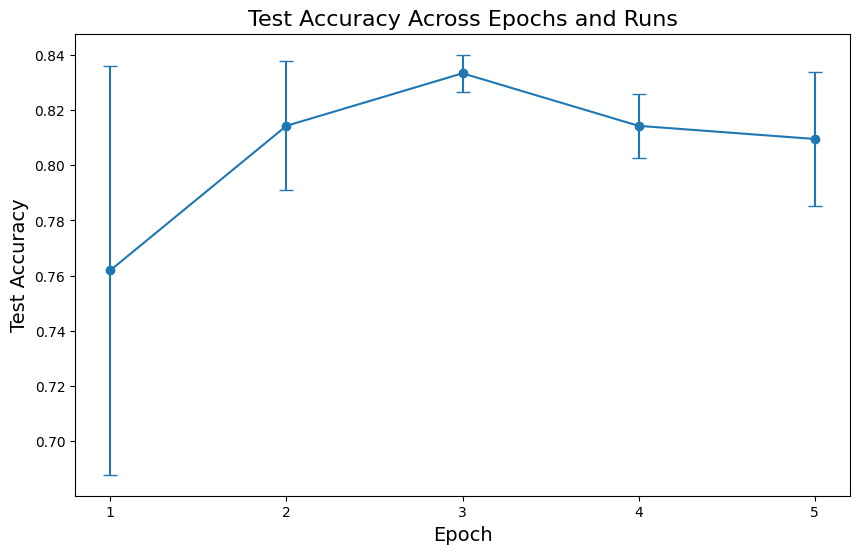

Epoch 1: Mean Accuracy = 0.7619, Std Dev = 0.0741
Epoch 2: Mean Accuracy = 0.8143, Std Dev = 0.0233
Epoch 3: Mean Accuracy = 0.8333, Std Dev = 0.0067
Epoch 4: Mean Accuracy = 0.8143, Std Dev = 0.0117
Epoch 5: Mean Accuracy = 0.8095, Std Dev = 0.0243


In [38]:
from sklearn.metrics import accuracy_score
from transformers import Trainer, TrainingArguments
import numpy as np
import torch
from tqdm import tqdm


def evaluate_on_test_set(model, test_dataset):
    model.eval()
    all_predictions = []
    all_labels = []
    dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(model.device)
            attention_mask = batch["attention_mask"].to(model.device)
            labels = batch["labels"].to(model.device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy

training_args = TrainingArguments(
    output_dir="./results",          
    per_device_train_batch_size=8,   
    weight_decay=0.01,              
    logging_dir="./logs",           
    logging_steps=10,               
    save_strategy="no",        
    seed=42,                  
)

num_runs = 3
max_epochs = 5
test_accuracies_all_runs = []

for run in range(num_runs):
    print(f"\nRun {run + 1}/{num_runs}")
    
    torch.manual_seed(42)
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
    )
    
    run_accuracies = []
    for epochs in range(1, max_epochs + 1):
        print(f"\nTraining for {epochs} epoch(s)...")
        
        trainer.args.num_train_epochs = epochs
        
        trainer.train()
        
        test_accuracy = evaluate_on_test_set(model, test_dataset)
        run_accuracies.append(test_accuracy)
        print(f"Test Accuracy after training for {epochs} epoch(s): {test_accuracy:.4f}")
    
    test_accuracies_all_runs.append(run_accuracies)

test_accuracies_all_runs = np.array(test_accuracies_all_runs)

mean_accuracies = np.mean(test_accuracies_all_runs, axis=0)
std_accuracies = np.std(test_accuracies_all_runs, axis=0)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.errorbar(range(1, max_epochs + 1), mean_accuracies, yerr=std_accuracies, fmt='-o', capsize=5)
plt.title("Test Accuracy Across Epochs and Runs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Test Accuracy", fontsize=14)
plt.xticks(range(1, max_epochs + 1))  
plt.grid(False)
plt.show()


for epoch in range(1, max_epochs + 1):
    print(f"Epoch {epoch}: Mean Accuracy = {mean_accuracies[epoch-1]:.4f}, Std Dev = {std_accuracies[epoch-1]:.4f}")


# Some plotting

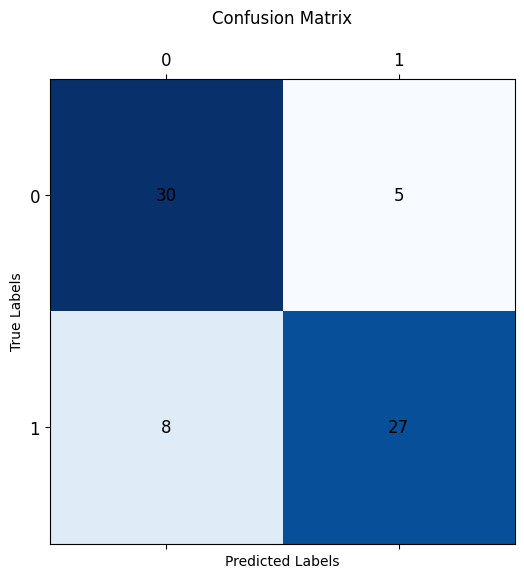

In [19]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 6))
plt.matshow(cm, cmap='Blues', fignum=1)

plt.title('Confusion Matrix', pad=20)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{cm[i, j]:d}', ha='center', va='center', color='black', fontsize=12)

plt.xticks([0, 1], ['0', '1'], fontsize=12)
plt.yticks([0, 1], ['0', '1'], fontsize=12)

plt.show()


In [25]:
from transformers import Trainer, TrainingArguments
import numpy as np

def train_and_log_accuracy(model, train_dataset, val_dataset, epoch_accuracies):
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir="./logs",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=lambda p: {"accuracy": accuracy_score(np.argmax(p.predictions, axis=1), p.label_ids)}
    )

    trainer.train()

    for log in trainer.state.log_history:
        if "eval_accuracy" in log:
            epoch_accuracies.append(log["eval_accuracy"])


In [27]:
import torch
from copy import deepcopy

num_experiments = 3
num_epochs = 3
all_accuracies = []

for _ in range(num_experiments):

    model = AutoModelForSequenceClassification.from_pretrained("seyonec/ChemBERTa_zinc250k_v2_40k", num_labels=2)
    
    epoch_accuracies = []
    
    train_and_log_accuracy(deepcopy(model), train_dataset, val_dataset, epoch_accuracies)
    
    all_accuracies.append(epoch_accuracies)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa_zinc250k_v2_40k and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.8474411964416504, 'eval_accuracy': 0.5571428571428572, 'eval_runtime': 1.3228, 'eval_samples_per_second': 52.92, 'eval_steps_per_second': 6.804, 'epoch': 1.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6662707328796387, 'eval_accuracy': 0.7571428571428571, 'eval_runtime': 1.1166, 'eval_samples_per_second': 62.69, 'eval_steps_per_second': 8.06, 'epoch': 2.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.624592125415802, 'eval_accuracy': 0.7428571428571429, 'eval_runtime': 0.7979, 'eval_samples_per_second': 87.727, 'eval_steps_per_second': 11.279, 'epoch': 3.0}
{'train_runtime': 60.3774, 'train_samples_per_second': 13.813, 'train_steps_per_second': 1.739, 'train_loss': 0.5433978126162574, 'epoch': 3.0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa_zinc250k_v2_40k and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/davidsegura/miniconda3/envs/env_cage/lib/python3.9/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6507176160812378, 'eval_accuracy': 0.7142857142857143, 'eval_runtime': 1.2457, 'eval_samples_per_second': 56.191, 'eval_steps_per_second': 7.225, 'epoch': 1.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6079772114753723, 'eval_accuracy': 0.7428571428571429, 'eval_runtime': 1.236, 'eval_samples_per_second': 56.636, 'eval_steps_per_second': 7.282, 'epoch': 2.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6051726341247559, 'eval_accuracy': 0.8428571428571429, 'eval_runtime': 0.9181, 'eval_samples_per_second': 76.245, 'eval_steps_per_second': 9.803, 'epoch': 3.0}
{'train_runtime': 58.2533, 'train_samples_per_second': 14.317, 'train_steps_per_second': 1.802, 'train_loss': 0.49925122942243305, 'epoch': 3.0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa_zinc250k_v2_40k and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/davidsegura/miniconda3/envs/env_cage/lib/python3.9/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6507176756858826, 'eval_accuracy': 0.7142857142857143, 'eval_runtime': 1.2625, 'eval_samples_per_second': 55.444, 'eval_steps_per_second': 7.129, 'epoch': 1.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6079772114753723, 'eval_accuracy': 0.7428571428571429, 'eval_runtime': 1.2227, 'eval_samples_per_second': 57.25, 'eval_steps_per_second': 7.361, 'epoch': 2.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6051725745201111, 'eval_accuracy': 0.8428571428571429, 'eval_runtime': 0.9378, 'eval_samples_per_second': 74.64, 'eval_steps_per_second': 9.597, 'epoch': 3.0}
{'train_runtime': 59.2423, 'train_samples_per_second': 14.078, 'train_steps_per_second': 1.772, 'train_loss': 0.4992512657528832, 'epoch': 3.0}


In [28]:
all_accuracies = np.array(all_accuracies)

mean_accuracies = np.mean(all_accuracies, axis=0)
std_accuracies = np.std(all_accuracies, axis=0)


In [29]:
print(f"Epochs length: {len(epochs)}")
print(f"Mean Accuracies length: {len(mean_accuracies)}")
print(f"Standard Deviations length: {len(std_accuracies)}")


TypeError: object of type 'int' has no len()

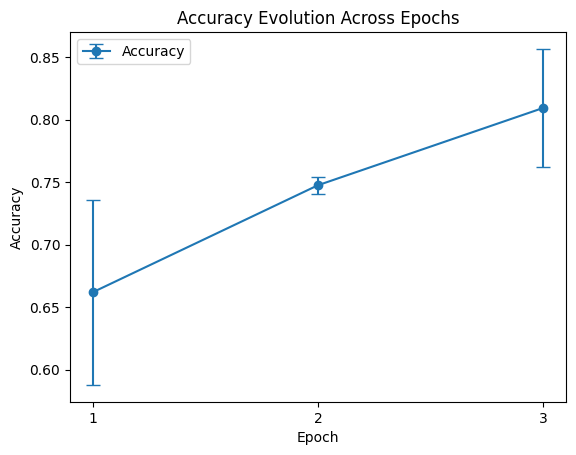

In [30]:
import matplotlib.pyplot as plt

epochs = np.arange(1, num_epochs + 1)

plt.errorbar(epochs, mean_accuracies, yerr=std_accuracies, fmt="-o", capsize=5, label="Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Evolution Across Epochs")
plt.xticks(epochs)  
plt.legend()

plt.grid(False)  
plt.show()


### Where is the attention graph

In [28]:
import torch
from copy import deepcopy
from transformers import AutoModelForSequenceClassification

num_experiments = 3
num_epochs = 3
all_accuracies = []

best_model = None
best_accuracy = float("-inf") 

for experiment_idx in range(num_experiments):

    model = AutoModelForSequenceClassification.from_pretrained("seyonec/ChemBERTa_zinc250k_v2_40k", num_labels=2)
    
    epoch_accuracies = []
    
    train_and_log_accuracy(deepcopy(model), train_dataset, val_dataset, epoch_accuracies)
    
    all_accuracies.append(epoch_accuracies)
    
    final_accuracy = epoch_accuracies[-1]
    
    if final_accuracy > best_accuracy:
        best_model = deepcopy(model)  
        best_accuracy = final_accuracy
        print(f"New best model found in experiment {experiment_idx} with accuracy: {best_accuracy}")

if best_model is not None:
    save_path = "/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/models"  
    best_model.save_pretrained(save_path)
    print(f"Best model saved to {save_path} with accuracy: {best_accuracy}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa_zinc250k_v2_40k and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/davidsegura/miniconda3/envs/env_cage/lib/python3.9/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6507174372673035, 'eval_accuracy': 0.7142857142857143, 'eval_runtime': 1.5106, 'eval_samples_per_second': 46.339, 'eval_steps_per_second': 5.958, 'epoch': 1.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6079772114753723, 'eval_accuracy': 0.7428571428571429, 'eval_runtime': 1.4091, 'eval_samples_per_second': 49.678, 'eval_steps_per_second': 6.387, 'epoch': 2.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6051726341247559, 'eval_accuracy': 0.8428571428571429, 'eval_runtime': 0.7188, 'eval_samples_per_second': 97.386, 'eval_steps_per_second': 12.521, 'epoch': 3.0}
{'train_runtime': 63.5583, 'train_samples_per_second': 13.122, 'train_steps_per_second': 1.652, 'train_loss': 0.49925122942243305, 'epoch': 3.0}
New best model found in experiment 0 with accuracy: 0.8428571428571429


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa_zinc250k_v2_40k and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/davidsegura/miniconda3/envs/env_cage/lib/python3.9/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6507178544998169, 'eval_accuracy': 0.7142857142857143, 'eval_runtime': 1.1131, 'eval_samples_per_second': 62.89, 'eval_steps_per_second': 8.086, 'epoch': 1.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6079772114753723, 'eval_accuracy': 0.7428571428571429, 'eval_runtime': 1.0277, 'eval_samples_per_second': 68.113, 'eval_steps_per_second': 8.757, 'epoch': 2.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6051725149154663, 'eval_accuracy': 0.8428571428571429, 'eval_runtime': 0.8648, 'eval_samples_per_second': 80.943, 'eval_steps_per_second': 10.407, 'epoch': 3.0}
{'train_runtime': 58.0208, 'train_samples_per_second': 14.374, 'train_steps_per_second': 1.81, 'train_loss': 0.4992512657528832, 'epoch': 3.0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa_zinc250k_v2_40k and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/davidsegura/miniconda3/envs/env_cage/lib/python3.9/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6507176160812378, 'eval_accuracy': 0.7142857142857143, 'eval_runtime': 1.1239, 'eval_samples_per_second': 62.281, 'eval_steps_per_second': 8.008, 'epoch': 1.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6079772114753723, 'eval_accuracy': 0.7428571428571429, 'eval_runtime': 1.0632, 'eval_samples_per_second': 65.84, 'eval_steps_per_second': 8.465, 'epoch': 2.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.6051725745201111, 'eval_accuracy': 0.8428571428571429, 'eval_runtime': 0.6718, 'eval_samples_per_second': 104.192, 'eval_steps_per_second': 13.396, 'epoch': 3.0}
{'train_runtime': 60.7162, 'train_samples_per_second': 13.736, 'train_steps_per_second': 1.729, 'train_loss': 0.4992511930919829, 'epoch': 3.0}
Best model saved to /Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/models with accuracy: 0.8428571428571429


In [80]:
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from IPython.display import display, HTML
import matplotlib

def extract_and_visualize_attention(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)

    attentions = outputs.attentions  
    last_layer_attention = attentions[-1] 
    mean_attention_per_token = last_layer_attention.mean(dim=1)  

    mean_attention_per_token = mean_attention_per_token.squeeze(0)  

 
    cls_attention = mean_attention_per_token[0, 1:].tolist()  

    decoded_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze(0).tolist(), skip_special_tokens=False)


    if len(decoded_tokens) - 1 != len(cls_attention):  
        print(f"Mismatch: {len(decoded_tokens) - 1} tokens, {len(cls_attention)} attention scores")
        decoded_tokens = decoded_tokens[:len(cls_attention) + 1]  

   
    epsilon = 1e-6
    if max(cls_attention) == min(cls_attention):
       
        normalized_attention = [i / (len(cls_attention) - 1) for i in range(len(cls_attention))]
    else:
        normalized_attention = [
            (score - min(cls_attention)) / (max(cls_attention) - min(cls_attention) + epsilon)
            for score in cls_attention
        ]

  
    def attention_to_color(attention_score):
        """Convert attention score to a red color intensity."""
        cmap = matplotlib.colormaps["Reds"] 
        rgba = cmap(attention_score)
        return matplotlib.colors.rgb2hex(rgba)

    html_content = "<div style='font-family: monospace; font-size: 16px; line-height: 1.6;'>"
    for word, score in zip(decoded_tokens[1:], normalized_attention): 
        color = attention_to_color(score)
        html_content += f"<span style='background-color: {color}; padding:2px; border-radius: 3px; margin: 1px;'>{word}</span> "
    html_content += "</div>"

    
    display(HTML(html_content))

    html_filename = "attention_heatmap.html"
    with open(html_filename, "w") as f:
        f.write(html_content)

    print(f"Attention heatmap saved to {html_filename}")

sample_text = val_texts[0]  
extract_and_visualize_attention(model, tokenizer, sample_text)


Attention heatmap saved to attention_heatmap.html
